In [3]:
import torch
import pandas as pd
import numpy as np
from transformers import MobileViTImageProcessor
import os
from dataset import MRIImageDataModule
from models import MobileViTLightning, EfficientNetBaseline
from utils import get_best_device

# Set device
device = get_best_device()

# Path to the CSV file
csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Define the models and slices
model_configs = {
    'MobileVit': {
        'model_ckpt': 'apple/mobilevit-small',
        'slice_numbers': ['65', '86', '56', '95', '62', '35', '59', '74', '80', '134']
    },
    'EfficientNetb0': {
        'model_ckpt': None,
        'slice_numbers': ['65', '86', '56', '95', '62', '35', '59', '74', '80', '134']
    }
}

# Load and preprocess the MRI dataset
def get_transform(model_name, model_ckpt):
    if model_name == "MobileVit":
        processor = MobileViTImageProcessor.from_pretrained(model_ckpt)
        return lambda image: processor(image, return_tensors="pt")["pixel_values"].squeeze(0)
    elif model_name == 'EfficientNetb0':
        return None

# Function to apply softmax after averaging predictions
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1, keepdims=True)

# Iterate over the models and slices
for model_name, config in model_configs.items():
    model_ckpt = config['model_ckpt']
    transform = get_transform(model_name, model_ckpt)
    results_dict = {'id': [], 'labels': []}
    model_predictions = []
    
    # Initialize a dictionary to store slice predictions
    slice_predictions = {f'slice_{slice_number}': [] for slice_number in config['slice_numbers']}

    for slice_number in config['slice_numbers']:
        model_path = f'model_checkpoints/{model_name}/slice_numer_{slice_number}.ckpt'
        if not os.path.exists(model_path):
            continue
        
        # Load the model
        if model_name == "MobileVit":
            model = MobileViTLightning.load_from_checkpoint(model_path, model_ckpt=model_ckpt, num_labels=4)
        elif model_name == 'EfficientNetb0':
            model = EfficientNetBaseline.load_from_checkpoint(model_path)

        model = model.to(device)
        model.eval()

        # Initialize the data module
        data_module = MRIImageDataModule(csv_path, slice_number=int(slice_number), transform=transform, batch_size=48, num_workers=0)
        data_module.setup()
        test_loader = data_module.test_dataloader()

        # Perform inference and store predictions
        all_preds = []
        all_labels = []
        all_ids = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels, age, ids = batch
                inputs = inputs.to(device).float()
                outputs = model(inputs)
                all_preds.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_ids.extend(ids)

        # Store predictions
        model_predictions.append(all_preds)
        slice_predictions[f'slice_{slice_number}'].extend(all_preds)
        if not results_dict['id']:
            results_dict['id'] = all_ids
            results_dict['labels'] = all_labels

    # Average predictions for each model and slice combination
    averaged_predictions = np.mean(model_predictions, axis=0)
    final_predictions = softmax(averaged_predictions)  # Apply softmax

    results_dict[model_name] = final_predictions.tolist()

    # Add individual slice predictions to the results_dict
    for slice_number in config['slice_numbers']:
        if f'slice_{slice_number}' in slice_predictions:
            results_dict[f'slice_{slice_number}'] = [str(pred) for pred in slice_predictions[f'slice_{slice_number}']]

    # Convert dictionary to DataFrame
    df_results = pd.DataFrame(results_dict)

    # Ensure rows are sorted by MRI ID
    df_results = df_results.sort_values(by='id')

    # Save DataFrame to CSV
    df_results.to_csv(f'{model_name}_predictions.csv', index=False)

    # Display DataFrame
    print(df_results.head())


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([4, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecat

              id  labels                                          MobileVit  \
0  OAS1_0015_MR1       1  [0.31572654843330383, 0.5214269757270813, 0.15...   
1  OAS1_0018_MR1       0  [0.9896863698959351, 0.009171140380203724, 0.0...   
2  OAS1_0030_MR1       0  [0.9286157488822937, 0.06423860788345337, 0.00...   
3  OAS1_0032_MR1       0  [0.21712152659893036, 0.47539305686950684, 0.2...   
4  OAS1_0042_MR1       1  [0.23014558851718903, 0.5036064386367798, 0.24...   

                                            slice_65  \
0  [ 0.93288845  1.5359979   0.39634442 -2.153315  ]   
1  [ 4.6502047   0.23598213 -1.6512191  -4.8900867 ]   
2      [ 3.6658711  1.1528562 -1.4227091 -4.416018 ]   
3  [ 0.49622518  1.2414142   0.7589155  -1.9343175 ]   
4  [ 0.7027445   1.7777799   0.48944175 -2.3012788 ]   

                                            slice_86  \
0  [ 0.01462289  1.1371214   0.47996795 -1.5866879 ]   
1  [ 4.543984   -0.41276544 -2.4831724  -3.8655887 ]   
2      [ 4.379257  -

/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

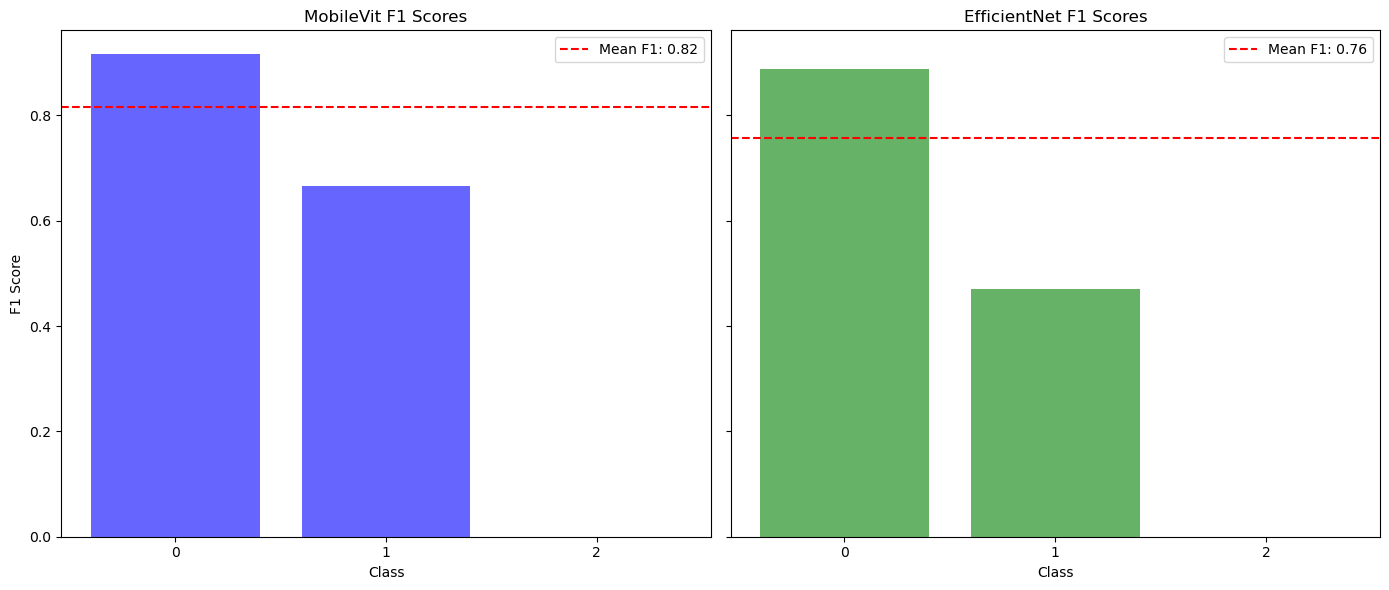

MobileVit Mean F1 Score: 0.8159182183278569
MobileVit Class-wise F1 Scores: {'0': 0.9156626506024096, '1': 0.6666666666666667, '2': 0.0}
EfficientNet Mean F1 Score: 0.7567439096850863
EfficientNet Class-wise F1 Scores: {'0': 0.888888888888889, '1': 0.4705882352941177, '2': 0.0}


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

# Load the CSV files into dataframes
mobilevit_df = pd.read_csv('MobileVit_predictions.csv')
efficientnet_df = pd.read_csv('EfficientNetb0_predictions.csv')

# Extract labels and predictions
y_true_mobilevit = mobilevit_df['labels'].tolist()
y_pred_mobilevit = mobilevit_df['MobileVit'].apply(eval).apply(np.argmax).tolist()

y_true_efficientnet = efficientnet_df['labels'].tolist()
y_pred_efficientnet = efficientnet_df['EfficientNetb0'].apply(eval).apply(np.argmax).tolist()

# Calculate F1 scores for MobileVit
report_mobilevit = classification_report(y_true_mobilevit, y_pred_mobilevit, output_dict=True)
mean_f1_mobilevit = report_mobilevit['weighted avg']['f1-score']
class_f1_mobilevit = {k: v['f1-score'] for k, v in report_mobilevit.items() if k.isdigit()}

# Calculate F1 scores for EfficientNet
report_efficientnet = classification_report(y_true_efficientnet, y_pred_efficientnet, output_dict=True)
mean_f1_efficientnet = report_efficientnet['weighted avg']['f1-score']
class_f1_efficientnet = {k: v['f1-score'] for k, v in report_efficientnet.items() if k.isdigit()}

# Prepare data for plotting
labels = sorted(set(y_true_mobilevit + y_true_efficientnet))
mobilevit_scores = [class_f1_mobilevit.get(str(label), 0) for label in labels]
efficientnet_scores = [class_f1_efficientnet.get(str(label), 0) for label in labels]

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# MobileVit plot
axes[0].bar(labels, mobilevit_scores, color='blue', alpha=0.6)
axes[0].axhline(mean_f1_mobilevit, color='red', linestyle='--', label=f'Mean F1: {mean_f1_mobilevit:.2f}')
axes[0].set_title('MobileVit F1 Scores')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('F1 Score')
axes[0].set_xticks(labels)
axes[0].set_xticklabels(labels)
axes[0].legend()

# EfficientNet plot
axes[1].bar(labels, efficientnet_scores, color='green', alpha=0.6)
axes[1].axhline(mean_f1_efficientnet, color='red', linestyle='--', label=f'Mean F1: {mean_f1_efficientnet:.2f}')
axes[1].set_title('EfficientNet F1 Scores')
axes[1].set_xlabel('Class')
axes[1].set_xticks(labels)
axes[1].set_xticklabels(labels)
axes[1].legend()

plt.tight_layout()
plt.show()

# Display mean F1 scores and class-wise F1 scores
print("MobileVit Mean F1 Score:", mean_f1_mobilevit)
print("MobileVit Class-wise F1 Scores:", class_f1_mobilevit)

print("EfficientNet Mean F1 Score:", mean_f1_efficientnet)
print("EfficientNet Class-wise F1 Scores:", class_f1_efficientnet)
